In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import json
import os
import yaml
from dask.distributed import Client

In [4]:
with open('/g/g92/haridev/.dlio_profiler/configuration.yaml', 'r') as file:
    dlp_yaml = yaml.safe_load(file)

In [5]:
# to make this notebook in dev mode.
import sys
sys.path.insert(0,dlp_yaml["APP"])
sys.path

['/usr/WS2/haridev/dlio-profiler',
 '/usr/WS2/haridev/dlio-profiler/examples/dlp_analyzer',
 '/usr/WS2/haridev/dlio-profiler/examples/dlp_analyzer',
 '/usr/workspace/iopp/projects/digio',
 '/collab/usr/gapps/python/build/spack-toss4.1/var/spack/environments/python/._view/75prb56irmif5ejtirjthpx6kq3gqo52/lib/python39.zip',
 '/collab/usr/gapps/python/build/spack-toss4.1/var/spack/environments/python/._view/75prb56irmif5ejtirjthpx6kq3gqo52/lib/python3.9',
 '/collab/usr/gapps/python/build/spack-toss4.1/var/spack/environments/python/._view/75prb56irmif5ejtirjthpx6kq3gqo52/lib/python3.9/lib-dynload',
 '',
 '/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages']

In [6]:
import dlp_analyzer
print(dlp_analyzer.__file__)
from dlp_analyzer.main import DLPAnalyzer,get_dlp_configuration,update_dlp_configuration,setup_logging,setup_dask_cluster, reset_dask_cluster, get_dlp_configuration

/usr/WS2/haridev/dlio-profiler/dlp_analyzer/__init__.py


In [7]:
dask_run_dir = os.path.join(dlp_yaml["APP"], "dlp_analyzer", "dask", "run_dir")
dask_run_dir

'/usr/WS2/haridev/dlio-profiler/dlp_analyzer/dask/run_dir'

In [8]:
with open (os.path.join(dask_run_dir, "scheduler.json"), "r") as f:
    dask_scheduler = json.load(f)
dask_scheduler

{'type': 'Scheduler',
 'id': 'Scheduler-89209c3b-66f7-4b23-9420-c0d0848be547',
 'address': 'tcp://134.9.71.27:10001',
 'services': {'dashboard': 8787},
 'started': 1698518019.2896266,
 'workers': {}}

In [9]:
app_name = "mummi" # resnet cosmoflow unet3d mummi deepspeed

In [10]:
def get_conditions_cosmoflow(json_object):
    app_io_cond = "TFReader.parse_image" in json_object["name"] # Cosmoflow
    compute_cond = "compute" in json_object["name"] # Cosmoflow
    io_cond = "POSIX" == json_object["cat"] # Cosmoflow
    return app_io_cond, compute_cond, io_cond

def get_conditions_resnet(json_object):
    app_io_cond = "IO" == json_object["cat"] # Resnet50
    compute_cond = "cpu" in json_object["name"] or "compute" in json_object["cat"] # Resnet50
    io_cond = "POSIX" == json_object["cat"] # Cosmoflow
    return app_io_cond, compute_cond, io_cond

def get_conditions_unet3d(json_object):
    app_io_cond = "NPZReader.read_index" in json_object["name"] # Unet3d
    compute_cond = "compute" in json_object["name"] # Unet3d
    io_cond = "POSIX" == json_object["cat"] # Cosmoflow
    return app_io_cond, compute_cond, io_cond


In [11]:
condition_fn = None
if app_name == "cosmoflow":
    filename = "/usr/WS2/iopp/kogiou1/dlio_benchmark/hydra_log/cosmoflow/2023-10-31-10-27-24/.trace*.pfw.gz"
    condition_fn = get_conditions_cosmoflow
elif app_name == "resnet":
    filename = "/usr/workspace/iopp/dlio_paper_results/resnet_50_1node_4ppn/*.pfw.gz"
    condition_fn = get_conditions_resnet
elif app_name == "unet3d":
    filename = "/usr/workspace/iopp/kogiou1/dlio_benchmark_logs/unet3d/node_32_ppn_4/.trace*.pfw.gz"
    condition_fn = get_conditions_unet3d
elif app_name == "mummi":
    filename = "/usr/workspace/iopp/dlp_traces/mummi-32-node/trace*.pfw.gz"
elif app_name == "mummi":
    filename = "/usr/workspace/iopp/dlp_traces/deep_speed_32_4ppn/*.pfw.gz"
else:
    raise Exception("Unknown App name")

In [28]:
conf = update_dlp_configuration(dask_scheduler=dask_scheduler["address"], verbose=True, 
                                log_file="./dlp.log", rebuild_index=False, time_approximate=True, 
                                host_pattern=r'lassen(\d+)', time_granularity=3600e6, skip_hostname=True, conditions=condition_fn)


In [29]:
conf = get_dlp_configuration()
conf.time_approximate

True

In [30]:
setup_logging()

In [31]:
setup_dask_cluster()

[INFO] [01:13:10] Initialized Client with 48 workers and link http://134.9.71.27:8787/status [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:625]


In [32]:
reset_dask_cluster()

[INFO] [01:13:17] Restarting all workers [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:617]


In [33]:
analyzer = DLPAnalyzer(filename)

[INFO] [01:13:20] Created index for 5849 files [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:333]
[INFO] [01:13:20] Total size of all files are <dask.bag.core.Item object at 0x1554a663f310> bytes [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:335]
[INFO] [01:13:23] Loading 6105 batches out of 5849 files and has 4506577 lines overall [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:348]
[INFO] [01:13:46] Loaded events [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:390]
[INFO] [01:13:46] Loaded plots with slope threshold: 45 [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:396]


In [34]:
analyzer.events.head()

,name,cat,pid,tid,ts,te,dur,tinterval,trange,hostname,compute_time,io_time,app_io_time,total_time,filename,phase,size
0,__xstat64,POSIX,7935,11634,4293,4307,14,<NA>,0.0,lassen262,<NA>,14,<NA>,14,<NA>,2,<NA>
1,__xstat64,POSIX,7935,11634,16980,20715,3735,<NA>,0.0,lassen262,<NA>,3735,<NA>,3735,<NA>,2,<NA>
2,open64,POSIX,7935,11634,20826,20962,136,<NA>,0.0,lassen262,<NA>,136,<NA>,136,<NA>,2,<NA>
3,__fxstat64,POSIX,7935,11634,21028,21032,4,<NA>,0.0,lassen262,<NA>,4,<NA>,4,<NA>,2,<NA>
4,lseek64,POSIX,7935,11634,21111,21117,6,<NA>,0.0,lassen262,<NA>,6,<NA>,6,<NA>,2,<NA>


In [35]:
#analyzer.events[["io_time","compute_time","app_io_time"]].max().compute() / 1e6

In [36]:
items = analyzer.summary()
items

[INFO] [01:13:47] Total number of events in the workload are 4500592 [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/main.py:488]
/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages/dask/dataframe/core.py:5983: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'int64'))

  warnings.warn(meta_warning(meta))
/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages/dask/dataframe/core.py:5983: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please pro

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│  Allocation    Scheduler Allocation Details                                                                     │
│                ├── Nodes: 32 ['lassen262', 'lassen592', 'lassen759', 'lassen591', 'lassen264', 'lassen432',     │
│                │   'lassen748', 'lassen435', 'lassen277', 'lassen752', 'lassen283', 'lassen269', 'lassen598',   │
│                │   'lassen762', 'lassen763', 'lassen750', 'lassen274', 'lassen105', 'lassen272', 'lassen429',   │
│                │   'lassen766', 'lassen765', 'lassen758', 'lassen273', 'lassen593', 'lassen278', 'lassen271',   │
│                │   'lassen421', 'lassen261', 'lassen106', 'lassen761', 'lassen103']                             │
│                ├── Processes: 22949 [318,180222]                                                                │
│                ├── Thread allocations across nodes (includes dynamically created threads)                       │
│                │   ├── Compute: 0                                                                               │
│                │   └── I/O: 2                                                                                   │
│                └── Events Recorded: 4500592                                                                     │
│  Dataset       Description of Dataset Used                                                                      │
│                └── Files: 1 ['<NA>']                                                                            │
│  I/O Behavior  Behavior of Application                                                                          │
│                ├── Split of Time in application                                                                 │
│                │   ├── Total Time: 42815.186 sec                                                                │
│                │   ├── Overall App Level I/O: 0.000 sec                                                         │
│                │   ├── Unoverlapped App I/O: 0.000 sec                                                          │
│                │   ├── Unoverlapped App Compute: 0.000 sec                                                      │
│                │   ├── Compute: 0.000 sec                                                                       │
│                │   ├── Overall I/O: 122.628 sec                                                                 │
│                │   ├── Unoverlapped I/O: 122.628 sec                                                            │
│                │   └── Unoverlapped Compute: 0.000 sec                                                          │
│                ├── Transfer size distribution by function                                                       │
│                │   ├── Function       |min   |25    |mean  |median|75    |max   |                               │
│                │   ├── __xstat64      |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                │   ├── open64         |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                │   ├── __fxstat64     |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                │   ├── lseek64        |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                │   ├── read           |NA    |NA    |11MB  |NA    |6KB   |588MB |                               │
│                │   ├── close          |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                │   ├── chdir          |NA    |nan   |nan   |NA    |nan   |NA    |                               │
│                │   ├── write          |1     |2KB   |148KB |2KB   |9KB   |3MB   |                               │
│                │   ├── mkdir          |NA    |nan   |n

In [37]:
analyzer.events.groupby("name")["size"].sum().compute() / 1024**3

name
__fxstat64      0.000000
__lxstat64      0.000000
__xstat64       0.000000
chdir           0.000000
close           0.000000
fcntl           0.000000
lseek64         0.000000
mkdir           0.000000
open64          0.000000
opendir         0.000000
read          297.803209
rmdir           0.000000
write          18.526814
Name: size, dtype: double[pyarrow]

In [38]:
analyzer.events.groupby(["trange","pid","tid", "name"])["io_time"].sum().groupby(["trange", "name"]).max().groupby([ "name"]).sum().compute() / 1e6

name
__fxstat64     0.062672
__lxstat64     0.010626
__xstat64     38.989014
chdir          0.009751
close          0.370562
fcntl          0.003346
lseek64        0.582429
mkdir          1.017002
open64        65.112464
opendir        0.005526
read          78.777624
rmdir          0.181852
write          5.461378
Name: io_time, dtype: double[pyarrow]

In [39]:
analyzer.events.groupby(["trange","pid","tid", "name"])["io_time"].count().groupby(["trange", "name"]).sum().groupby([ "name"]).sum().compute()

name
__fxstat64     134085
__lxstat64        613
__xstat64     2793041
chdir            1378
close          133027
fcntl             613
lseek64        993532
mkdir          101346
open64         182754
opendir          1328
read            27220
rmdir             613
write          131042
Name: io_time, dtype: int64[pyarrow]

In [40]:
timeline = analyzer.plots._create_timeline( analyzer.events).compute()

/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1032: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mins = mins.fillna(method="bfill").tolist()
/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1033: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  maxes = maxes.fillna(method="bfill").tolist()


In [41]:
timeline

,phase,index,size,io_time,app_io_time
trange,,,,,
0.0,2,26980,83569221721,20276776,0
1.0,2,20370,106289558574,29887190,0
2.0,2,20206,104076009743,26855887,0
3.0,2,15315,33793674947,9909920,0
4.0,2,12888,2036326833,3344295,0
5.0,2,12918,2052509591,3227027,0
6.0,2,13017,2049873026,2835722,0
7.0,2,12759,2022749559,2810273,0
8.0,2,12547,1983227782,8771249,0


/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1032: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mins = mins.fillna(method="bfill").tolist()
/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1033: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  maxes = maxes.fillna(method="bfill").tolist()


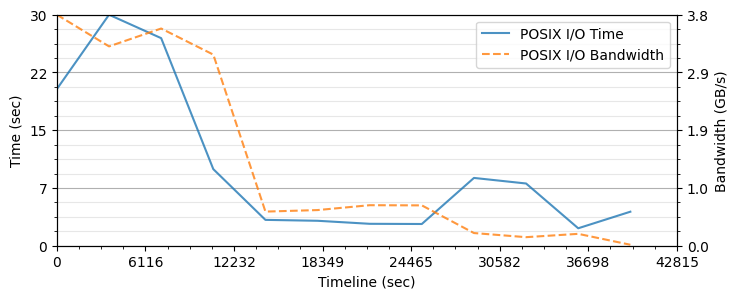

In [49]:
fig, ax1, ax2 = analyzer.plots.time_bw_timeline(
    bw_unit='gb',
    figsize=(8, 3),
    line1_label='POSIX I/O Time',
    line2_label='POSIX I/O Bandwidth',
    time_col='io_time',
    x_num_ticks=8,
    y_num_ticks=5,
)

In [50]:
fig.savefig(f'{app_name}_posix_io_time.pdf', format='pdf', bbox_inches='tight')

/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1032: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mins = mins.fillna(method="bfill").tolist()
/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1033: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  maxes = maxes.fillna(method="bfill").tolist()


TypeError: boolean value of NA is ambiguous

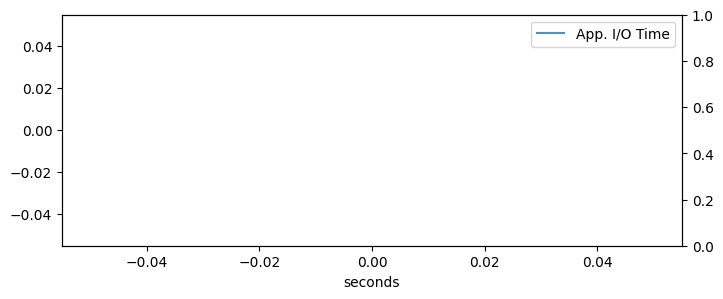

In [44]:
fig, ax1, ax2 = analyzer.plots.time_bw_timeline(
    bw_unit='kb',
    figsize=(8, 3),
    line1_label='App. I/O Time',
    line2_label='App. I/O Bandwidth',
    time_col='app_io_time',
    x_num_ticks=8,
    y_num_ticks=5,
)

In [ ]:
fig.savefig(f'{app_name}_app_io_time.pdf', format='pdf', bbox_inches='tight')

/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1032: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mins = mins.fillna(method="bfill").tolist()
/usr/WS2/haridev/venvs/venv-dlp_analuzer/lib/python3.9/site-packages/dask/dataframe/shuffle.py:1033: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  maxes = maxes.fillna(method="bfill").tolist()


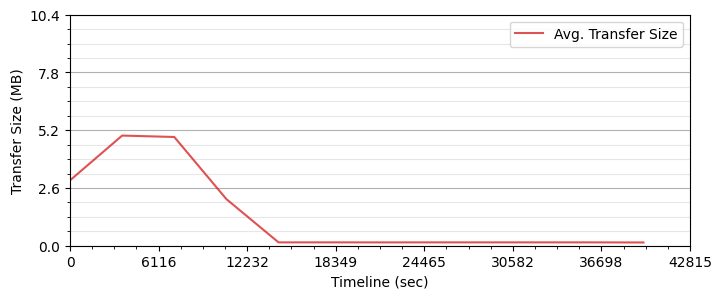

In [47]:
fig, ax = analyzer.plots.xfer_size_timeline(
    figsize=(8, 3),
    unit='mb',
    x_num_ticks=8,
)

In [48]:
fig.savefig(f'{app_name}_xfer_size.pdf', format='pdf', bbox_inches='tight')

In [29]:
analyzer.events.query("cat == 'POSIX'").groupby("name")["size"].mean().compute() / (1024**2)

name
__fxstat64        NaN
__xstat64         NaN
close             NaN
lseek64           NaN
open64            NaN
opendir           NaN
read          0.05467
Name: size, dtype: double[pyarrow]

In [29]:
analyzer.events.query("cat == 'POSIX'").groupby(["trange","pid","tid","name"])["io_time"].sum().groupby(["trange","name"]).max().groupby("name").sum().compute() / 1e6

name
__fxstat64     1.244447
__xstat64      3.215289
close          1.323762
lseek64        0.346017
open64         1.379163
opendir        3.505572
read          51.215883
Name: io_time, dtype: double[pyarrow]

In [30]:
val = analyzer.events.groupby(["trange"]).agg({"io_time":[min,max],"compute_time":[min,max],"app_io_time":[min,max]}).sum().compute()
val

io_time       min           0
              max     3234048
compute_time  min     5443261
              max     5475947
app_io_time   min      560089
              max    46578050
dtype: uint64[pyarrow]

In [17]:
val = analyzer.events["app_io_time"].max().compute()
val

21788614

In [22]:
import dask
val1, val2 = dask.compute(analyzer.events["ts"].min() /1e6 , analyzer.events["ts"].max()/1e6)
val2 - val1

105.51145505905151

In [19]:
analyzer.events["hostname"].unique().compute()[:2]

0    ruby165
1    ruby926
Name: hostname, dtype: string

In [23]:
analyzer.events.query("cat == 'POSIX'").groupby(["trange","name"])["dur"].max().sum().compute() / 1e6

3.809511

In [ ]:
analyzer.events.query("name == 'open'").groupby("trange")["dur"].max().sum().compute() / 1e6

In [20]:
analyzer.events.groupby(["cat","name"])["dur"].sum().compute()

cat             name                                 
POSIX           __xstat64                                      24806
                close                                       24829534
                open                                       245486865
                opendir                                     13279902
                pread                                    18136305739
ai_framework    TFFramework.compute                        767751183
                TFFramework.get_loader                          1482
                TFFramework.init_loader                     42020267
                TFFramework.is_nativeio_available                917
                TFFramework.trace_object                      193915
config          ConfigArguments.build_sample_map_iter     1479302011
                ConfigArguments.derive_configurations         567405
                ConfigArguments.reconfigure               1500802333
                ConfigArguments.validate         

In [23]:
3766287/3.8/1e6, 1022647/3.8/1e6, 1080267/3.8/1e6, 178451/3.8/1e6, (1259124+153089)/3.8/1e6

(0.9911281578947368,
 0.26911763157894736,
 0.28428078947368424,
 0.04696078947368421,
 0.371635)

[INFO] [19:04:51]            index         size  total_time  io_time  app_io_time
trange                                                         
28310475  237503   3435904036     9089266  3197221      9089266
28310476  557618   9055766762     5042545  2457928      5042545
28310477  603290   9753737591     2734682  2119446      2734682
28310478  655063  10582738192     3606051  2089019      3606051
28310479  683200  11006549057     4613653  1930037      4613653 [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/plots.py:224]
[INFO] [19:04:51]            index         size  total_time  io_time  app_io_time
trange                                                         
28310475  237503   3435904036     9089266  3197221      9089266
28310476  557618   9055766762     5042545  2457928      5042545
28310477  603290   9753737591     2734682  2119446      2734682
28310478  655063  10582738192     3606051  2089019      3606051
28310479  683200  11006549057     4613653  1930037      4613653 [/usr/WS2

(<Figure size 800x400 with 1 Axes>,
 <Axes: xlabel='Timeline (sec)', ylabel='I/O Time (sec)'>)

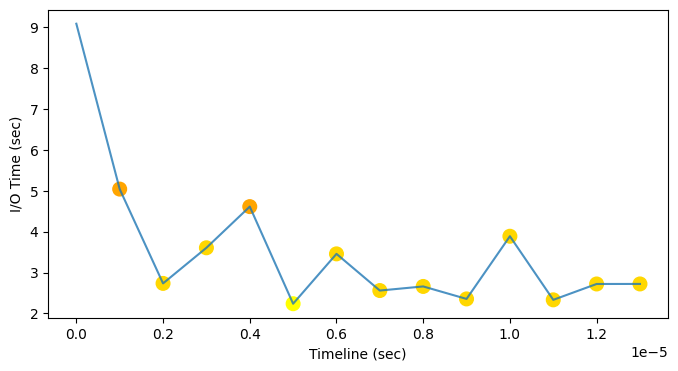

In [21]:
analyzer.plots.bottleneck_timeline(figsize=(8, 4))

In [ ]:
analyzer.plots.bw_timeline(figsize=(4, 4), unit='KB')

[INFO] [13:52:38]             index           size  total_time  io_time  app_io_time
trange                                                            
21229401  6398146  6057549130908    21788614  1320738     21788614
21229402  5598058  6039041094497     5366465   299441      5366465 [/usr/WS2/haridev/dlio-profiler/dlp_analyzer/plots.py:224]


<Axes: xlabel='Transfer Sizes', ylabel='Frequency'>

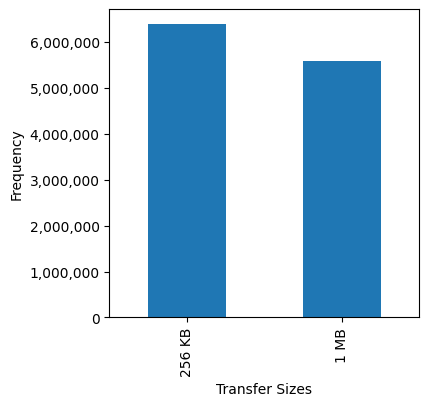

In [35]:
analyzer.plots.xfer_size_distribution(figsize=(4, 4))